In [3]:
import datetime
import altair as alt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time 
import multiprocessing as mp
from sklearn.decomposition import PCA
char = ['beta','a2me','log_at','ato','beme','c','cto','d2a','dpi2a','e2p','fc2y',
       'free_cf','idio_vol','investment','lev','size','lturnover','noa','oa','ol','pcm',
        'pm','prof','q','rel_to_high_price','rna','roa','roe',
        'cum_return_12_2','cum_return_12_7','cum_return_1_0','cum_return_36_13',
        's2p','sga2s','spread_mean','suv']

df_ = pd.read_csv("Data/Characteristics Freyberger et al.csv", index_col = 0)
df_['size'] = np.log10(df_['lme'])
df_['log_at'] = np.log10(df_['at'])
df_['sga2s'] = df_['sga2m']/df_['a2me']/df_['ato']
df_.sort_values(by = ['yy', 'mm', 'permno']);

print("Column names:\n", list(df_))
df = df_.iloc[np.random.choice(df_.shape[0], 100),:][['yy','mm','date','permno','ret']+char]
print("Dataframe shape:", df_.shape)
print("Number of unique stocks:", pd.unique(df_['permno']).shape[0])
print("Number of unique dates:", pd.unique(df_['date']).shape[0])
print("Sub-sampled dataframe shape:", df.shape)
df.head()

stocks = pd.unique(df_['permno'])
N = stocks.shape[0]
Ts = pd.unique(df_['date']).tolist()
Ts = [t for t in Ts if not (int(t[-2:])<=70 and int(t[-2:])>=60)]
T = len(Ts)

# # Generate Zt's 
# N_s_by_t = []
# common_stocks = np.loadtxt("./common_stocks.csv", dtype=np.int)
# Zts = np.zeros((len(common_stocks),len(char),len(Ts)))
# rs = np.zeros((len(common_stocks),len(Ts)))
# for i_t in range(T): 
#     t = Ts[i_t]  # date 
#     df_t = df_.loc[df_['date']==t,['permno','ret']+char]
#     df_t = df_t.loc[df_t['permno'].apply(lambda x: x in set(common_stocks)),:]
#     Zt = df_t.sort_values(by="permno")
#     if not i_t % 100: print(t, Zt.shape[0])
#     N_s_by_t.append(Zt.shape[0])
#     # Zts.append(Zt[char])
#     Zts[:,:,i_t] = Zt[char]
#     rs[:,i_t] = df_t['ret']
# Zts_save = np.array(Zts, copy=True)

# # Augment characteristics 
# Zts = np.array(Zts_save, copy=True)

# # normalize rank 
# Zts = np.argsort(Zts, axis=0)/Zts.shape[0]-.5
# print("Zts.shape (N,L,T)", Zts.shape)
# print("np.amax(Zts)", np.amax(Zts))
# print("np.amin(Zts)", np.amin(Zts))

# Zt_cov = np.zeros((Zts.shape[1],Zts.shape[1],Zts.shape[2]))
# x_t = np.zeros((Zts.shape[1],Zts.shape[2]))
# for i_t in range(Zts.shape[2]):
#     Zt = Zts[:,:,i_t]
#     Zt_cov[:,:,i_t] = (Zt.T).dot(Zt)
#     if i_t<Zts.shape[2]-1:
#         x_t[:,i_t] = (Zt.T).dot(rs[:,i_t+1])

Column names:
 ['yy', 'mm', 'date', 'permno', 'ret', 'q10', 'q20', 'q50', 'prc', 'a2me', 'ato', 'beme', 'c', 'cto', 'd2a', 'dpi2a', 'e2p', 'fc2y', 'free_cf', 'investment', 'lme', 'lturnover', 'noa', 'oa', 'ol', 'pcm', 'pm', 'prof', 'q', 'rna', 'roa', 'roe', 's2p', 'sga2m', 'at', 'beta', 'cum_return_12_2', 'cum_return_12_7', 'cum_return_1_0', 'cum_return_36_13', 'idio_vol', 'spread_mean', 'suv', 'rel_to_high_price', 'lev', 'size', 'log_at', 'sga2s']
Dataframe shape: (1048575, 48)
Number of unique stocks: 7593
Number of unique dates: 623
Sub-sampled dataframe shape: (100, 41)


## Preprocessing Common Stocks and Zts

In [83]:
T = len(Ts)
stocks = np.sort(stocks)
stock_presence = np.empty((stocks.shape[0],T),dtype='bool')
for i_t in range(T): 
    t = Ts[i_t]  # date 
    df_t = df_.loc[df_['date']==t,['yy','permno']]
    stock_presence[:,i_t] = np.isin(stocks,df_t['permno'].unique())
    
# Generate Zt's 
N_s_by_t = []
common_stocks = stocks #np.loadtxt("./common_stocks.csv", dtype=np.int)
start=time.time()
Zts = np.empty((len(common_stocks),len(char),len(Ts)))
rs = np.empty((len(common_stocks),len(Ts)))
for i_t in range(T): 
    t = Ts[i_t]  # date 
    df_t = df_.loc[df_['date']==t,['permno','ret']+char]
    #df_t = df_t.loc[df_t['permno'].apply(lambda x: x in set(common_stocks)),:]
    Zt = df_t.sort_values(by="permno")
    if not i_t % 100: print(t, Zt.shape[0])
    N_s_by_t.append(Zt.shape[0])
    # Zts.append(Zt[char])
    Zts[stock_presence[:,i_t],:,i_t] = Zt[char]
    rs[stock_presence[:,i_t],i_t] = df_t['ret']
Zts_save = np.array(Zts, copy=True)
rs_save = np.array(rs,copy=True)

1/31/71 1191
5/31/79 1464
9/30/87 2587
1/31/96 3088
5/31/04 1575
9/30/12 999


## Rolling Window Approach

In [63]:
%load_ext autoreload
%autoreload 2
from ipca_restricted import ipca_restricted
K = 5
T_window = 120
fact_ret = np.zeros((K,T-T_window+1))
for i_t in range(T_window,T):
    #start_time =time.time()
    common_stock_index = np.prod(stock_presence[:,(i_t-T_window):i_t],axis=1,dtype='bool')
    # Generate Zt's 
    Zts = Zts_save[common_stock_index, :, (i_t-T_window):i_t]
    rs = rs_save[common_stock_index,(i_t-T_window):i_t]
    #print(Zts.shape)
    Zts = np.argsort(Zts,axis=0)/Zts.shape[0]-.5
    Zt_cov = np.zeros((Zts.shape[1],Zts.shape[1],Zts.shape[2]))
    x_t = np.zeros((Zts.shape[1],Zts.shape[2]))
    for i in range(Zts.shape[2]):
        Zt = Zts[:,:,i]
        Zt_cov[:,:,i] = (Zt.T).dot(Zt)
        if i<Zts.shape[2]-1:
            x_t[:,i] = (Zt.T).dot(rs[:,i+1])
    mid_time = time.time()
    F_1, Gamma_b_0, max_abs_delta_F, max_abs_delta_Gamma_b = ipca_restricted(Zts, Zt_cov, x_t, K, T_window)
    # Compute out of sample realized factor 
    fact_ret[:,i_t-T_window]= np.linalg.inv((Gamma_b_0.T).dot(Gamma_b_0)).dot(Gamma_b_0.T).dot(Zts[:,:,-1].T).dot(rs_save[common_stock_index,i_t])
    #fact_ret[:,i_t-T_window]= np.linalg.inv((Gamma_b_0.T).dot(Zt_cov[:,:,-1]).dot(Gamma_b_0)).dot(Gamma_b_0.T).dot(Zts[:,:,-1].T).dot(rs_save[common_stock_index,i_t])
    #end_time = time.time()
    #print('iteration', i_t)
    #print('fact_return', fact_ret)
    #print('preprocess time', mid_time - start_time)
    #print('alg time', end_time - mid_time)
    #print('total time', end_time - start_time)
    #if not i_t %10:
    print(i_t)

#UNIVARIATE SHARPE RATIO
fact_mean_ret = np.mean(fact_ret,axis=1)
fact_var = np.var(fact_ret,axis=1)
single_fact_SR = fact_mean_ret/fact_var 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347


In [44]:
np.mean(fact_ret)

-0.0002486387922129663

In [82]:
np.sum(np.arange(6).reshape(2,3),axis=0)
# np.savetxt('factor_return_PCA_only.csv', fact_ret)

array([3, 5, 7])

In [48]:
fact_mean_ret

array([ 0.0001208 , -0.00056324, -0.00068263,  0.00043659, -0.0005547 ])

In [36]:
import numpy as np
fact_ret = np.loadtxt('factor_return_PCA_only.csv')

In [37]:
port_ret = np.mean(fact_ret,axis=0)
port_mean = np.mean(port_ret)
port_sd = np.std(port_ret)
port_mean/port_sd

-0.049726161908893604

In [38]:
fact_mean = np.mean(fact_ret,axis=1)
fact_var= np.cov(fact_ret)

In [39]:
np.sqrt(fact_mean.T.dot(np.linalg.inv(fact_var)).dot(fact_mean))*np.sqrt(12)

0.27372468807996764

In [70]:
fact_mean

array([-0.02393475, -0.06295321, -0.04877859,  0.00248149,  0.00542439])

## All stocks

In [85]:
%reload_ext autoreload
%autoreload 2
from ipca_restricted import ipca_restricted
K = 5
Zts = np.array(Zts_save,copy=True)
rs = np.array(rs_save,copy=True)
Zts = np.argsort(Zts,axis=0)/np.sum(stock_presence,axis=0)-0.5
print(np.amax(Zts))
print(np.amin(Zts))
Zt_cov = np.zeros((Zts.shape[1],Zts.shape[1],Zts.shape[2]))
x_t = np.zeros((Zts.shape[1],Zts.shape[2]))
for i in range(Zts.shape[2]):
    Zt = Zts[:,:,i]
    Zt_cov[:,:,i] = (Zt.T).dot(Zt)
    if i<Zts.shape[2]-1:
        x_t[:,i] = (Zt.T).dot(rs[:,i+1])

7.375518672199171
-0.5


In [33]:
%load_ext autoreload
%autoreload 2
F_1, Gamma_b_0, max_abs_delta_F, max_abs_delta_Gamma_b,_,_ = ipca_restricted(Zts, Zt_cov, x_t, K, T,init=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
iter 0 	max_abs_delta_F 0.5034621485455693 	max_abs_delta_Gamma_b 0.09443380710135368
iter 100 	max_abs_delta_F 1.603222497351719e-08 	max_abs_delta_Gamma_b 1.5360269107395074e-06
iter 104 	max_abs_delta_F 9.706499252999013e-09 	max_abs_delta_Gamma_b 9.296211590257348e-07
Elapsed time 27.98067307472229


In [35]:
#IN SAMPLE R2
model_rt = np.zeros((rs.shape[0],rs.shape[1]-1))
for i_t in range(model_rt.shape[1]):
    model_rt[:,i_t] = Zts[:,:,i_t].dot(Gamma_b_0.dot(F_1[:,i_t+1]))
total_noise = np.linalg.norm(rs[:,1:] - model_rt)**2
rt_var = np.linalg.norm(rs[:,1:])**2
total_r2 = 1- total_noise/rt_var
print(total_r2) 

0.035198823553110214


In [51]:
mat = np.zeros_like(Zt_cov)
diagonals = np.zeros(Zts.shape[1:])
singular_values = np.zeros(Zts.shape[1:])
traces = np.zeros(Zts.shape[2])
negative_off_diag = np.zeros(Zts.shape[2])
for i in range(Zts.shape[2]):
    #mat[:,:,i] = (np.linalg.inv(np.linalg.cholesky(Zts[:,:,i].T.dot(Zts[:,:,i]))).dot(Zts[:,:,i].T)).T
    mat[:,:,i] = np.linalg.inv(Zt_cov[:,:,i])#/np.sum(stock_presence[:,i]))
    #mat = Zts[:,:,i].T
    U, S, V = np.linalg.svd(mat[:,:,i])
    singular_values[:,i] = S
    #traces[i] = np.trace(mat[:,:,i])
    traces[i] = np.sum(S)
    diagonals[:,i] = np.diag(mat[:,:,i])
    #diagonals[:,i] = mat[:,0,i]
    #negative_off_diag[i] = np.sum(mat < 0)/Zts.shape[1]/(Zts.shape[1]-1)
    #negative_off_diag[i] = np.sum(mat[mat < 0])

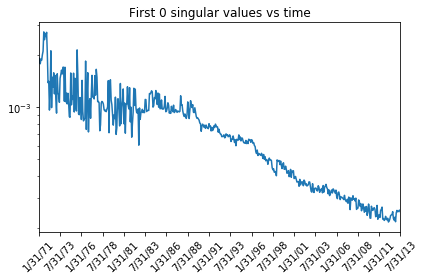

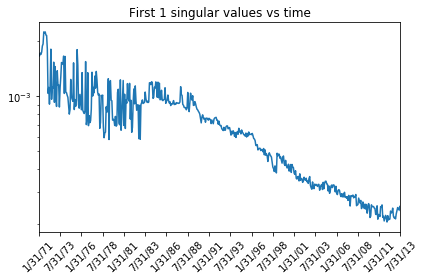

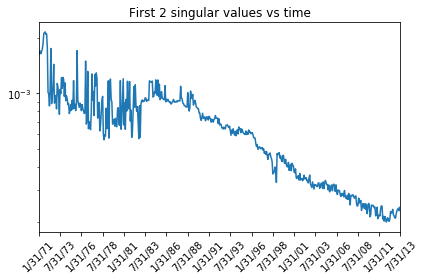

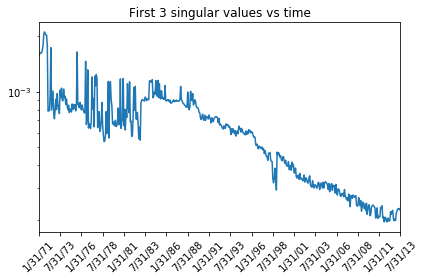

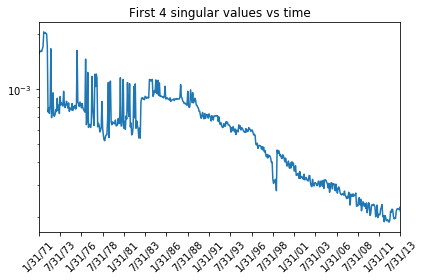

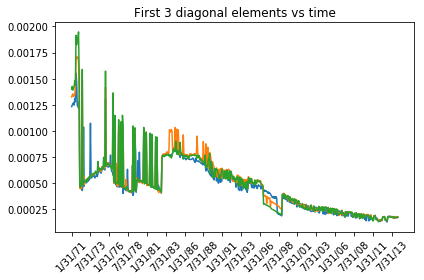

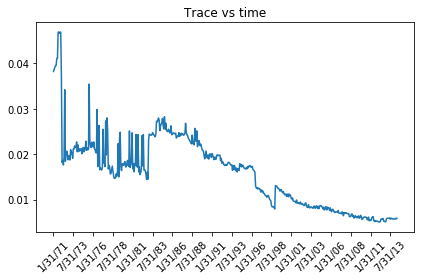

In [70]:
for i in range(5):
    first_n = i
    plt.figure(); plt.plot(singular_values.T[:,first_n]);
#     plt.ylim([0.00019,0.0005]); 
    plt.title("First "+str(first_n)+" singular values vs time");
    select_labels = np.arange(singular_values.shape[1]//1000000,singular_values.shape[1],30);
    plt.xlim([select_labels[0], select_labels[-1]]);
    plt.yscale("log");
    plt.xticks(select_labels, labels=[Ts[i] for i in select_labels], rotation=45);
    plt.tight_layout(); 

first_n = 3
plt.figure(); plt.plot(diagonals.T[:,:first_n]);
plt.title("First "+str(first_n)+" diagonal elements vs time");
select_labels = np.arange(0,singular_values.shape[1],30);
plt.xticks(select_labels, labels=[Ts[i] for i in select_labels], rotation=45);
plt.tight_layout(); 

plt.figure(); plt.plot(traces);
plt.title("Trace vs time");
select_labels = np.arange(0,singular_values.shape[1],30);
plt.xticks(select_labels, labels=[Ts[i] for i in select_labels], rotation=45);
plt.tight_layout(); 

# plt.figure(); plt.plot(negative_off_diag);
# plt.title("Negative values off diagonals vs time");
# select_labels = np.arange(0,singular_values.shape[1],30);
# plt.xticks(select_labels, labels=[Ts[i] for i in select_labels], rotation=45);
# plt.tight_layout(); 

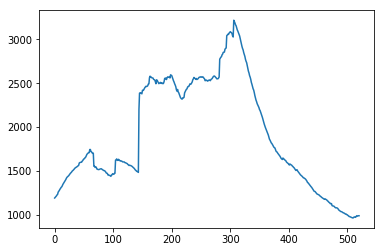

In [50]:
plt.plot(np.sum(stock_presence,axis=0))

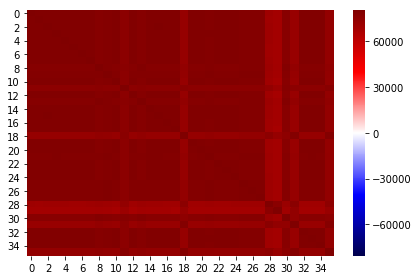

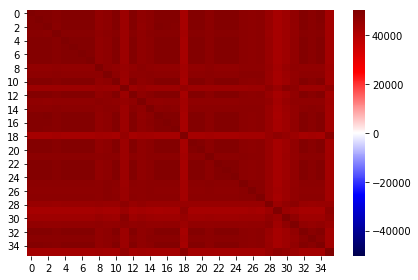

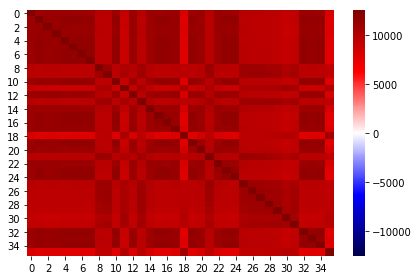

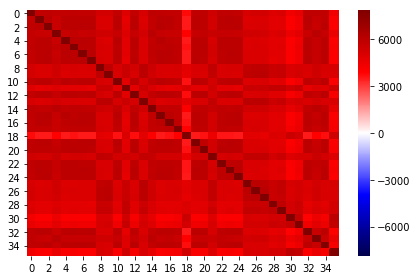

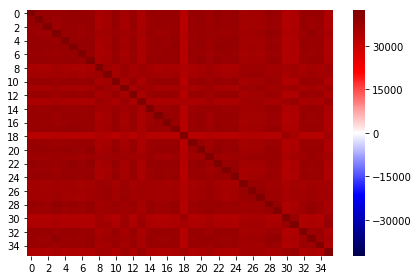

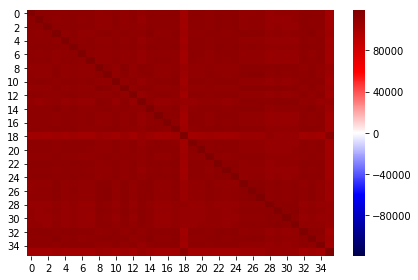

In [77]:
for i in range(0, Zt_cov.shape[2], 100):
#     mat = np.linalg.inv(Zt_cov[:,:,i])
    mat = Zt_cov[:,:,i]
    vlimit = np.amax(np.abs(mat));
#     vlimit = .001
    
    plt.figure(); 
    sns.heatmap(mat, cmap="seismic", vmin=-vlimit, vmax=vlimit);
    plt.tight_layout();

In [78]:
Zt_cov[:,:,0]

array([[80548.81614223, 79701.63895903, 79657.27684209, ...,
        79754.11884209, 79763.62070218, 74152.91578262],
       [79701.63895903, 80548.81614223, 79850.54368458, ...,
        79729.06251564, 79825.62419747, 74081.60551269],
       [79657.27684209, 79850.54368458, 80548.81614223, ...,
        79716.03995982, 79747.56268096, 74146.8887671 ],
       ...,
       [79754.11884209, 79729.06251564, 79716.03995982, ...,
        80548.81614223, 79734.65295288, 74133.58359629],
       [79763.62070218, 79825.62419747, 79747.56268096, ...,
        79734.65295288, 80548.81614223, 74081.35759749],
       [74152.91578262, 74081.60551269, 74146.8887671 , ...,
        74133.58359629, 74081.35759749, 80548.81614223]])

In [79]:
Zts[:,:,0]

array([[ 1.20528967, -0.5       , -0.5       , ...,  2.48740554,
        -0.5       ,  0.71242653],
       [ 0.19941226,  3.75440806,  3.75440806, ...,  2.37657431,
         3.75440806,  1.31444165],
       [ 0.43366919,  3.75356843,  3.75356843, ..., -0.04156171,
         3.75356843,  1.07934509],
       ...,
       [ 1.94248531,  1.0440806 ,  0.35054576, ...,  1.64189757,
         1.87615449,  1.97774979],
       [ 1.20780856,  2.34550798,  0.2691016 , ...,  1.9643157 ,
         2.44290512,  0.78799328],
       [ 2.51427372,  1.20780856, -0.32367758, ...,  2.2774979 ,
         1.70822838,  1.41939547]])

7.375518672199171

In [82]:
Zts = Zts_save 